In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fourvec import *

In [75]:
m4_model = {
    "L1": 0.42,
    "L2": 0.1,
    "H1": 0.12,
}

mzprime_model = {
    "L1": 0.03,
    "L2": 0.03,
    "H1": 1.25,
}

ctau_model = {
    "L1": [0.1, 1, 10, 100, 1000],
    "L2": [0.1, 1, 10, 100, 1000],
    "H1": [0.1, 2, 10, 100, 1000],
}

!mkdir ../../fig/bp_l1/
!mkdir ../../fig/bp_l2/
!mkdir ../../fig/bp_h1/

save_folder_model = {
    "L1": "../../fig/bp_l1/",
    "L2": "../../fig/bp_l2/",
    "H1": "../../fig/bp_h1/",
}

mkdir: cannot create directory ‘../../fig/bp_l1/’: File exists
mkdir: cannot create directory ‘../../fig/bp_l2/’: File exists
mkdir: cannot create directory ‘../../fig/bp_h1/’: File exists


In [78]:
model = "H1"
m4 = m4_model[model]
mzprime = mzprime_model[model]
ctaus = ctau_model[model]
save_folder = save_folder_model[model]

In [63]:
def decay_particle(df, ctau):
    p3dark = np.sqrt(dot3_df(df['pdark'], df['pdark']))
    mdark = inv_mass(df['pdark'])
    betagamma = p3dark/mdark
    gamma = df['pdark', 't']/mdark
    beta = betagamma/gamma
    
    d_decay = np.random.exponential(scale=ctau*betagamma) # centimeters

    df[f'decay_point_{ctau}', 't'] = df['int_point', 't'] + d_decay/(2.998e+10 * beta)
    df[f'decay_point_{ctau}', 'x'] = df['int_point', 'x'] + d_decay*df['pdark', 'x']/p3dark
    df[f'decay_point_{ctau}', 'y'] = df['int_point', 'y'] + d_decay*df['pdark', 'y']/p3dark
    df[f'decay_point_{ctau}', 'z'] = df['int_point', 'z'] + d_decay*df['pdark', 'z']/p3dark

In [64]:
df = pd.read_pickle(f'../data/nd280_nu/3plus1/m4_{m4}_mzprime_{mzprime}/MC_m4_{m4}_mzprime_{mzprime}.pckl')

In [65]:
print(len(df))

341100


In [66]:
# compute useful variables
for comp in ['t','x','y','z']:
    df['pee', comp] = df['plm', comp] + df['plp', comp]
    df['pdark', comp] = df['plm', comp] + df['plp', comp] + df['pnu', comp]
df['recoil_mass', ''] = inv_mass(df['pHad']).round(6)
df['ee_mass', ''] = inv_mass(df['pee'])
df['ee_costheta', ''] = costheta(df['plm'], df['plp'])
df['ee_beam_costheta', ''] = df['pee', 'z']/np.sqrt(dot3_df(df['pee'], df['pee']))
df['ee_momentum', ''] = np.sqrt(dot3_df(df['pee'], df['pee']))
df['experimental_t', ''] = (df['plm','t'] - df['plm','z'] + df['plp','t'] - df['plp','z'])**2 +\
                               df['plm','x']**2 + df['plm','y']**2 + df['plp','x']**2 + df['plp','y']**2

In [67]:
selection = (df['ee_beam_costheta', ''] > 0.99) &\
            (df['ee_costheta', ''] > 0) &\
            (df['experimental_t', ''] < 0.03) &\
            (df['ee_momentum', ''] > 0.150)

In [68]:
total_pot = 2e21

tpc_length = 100 #cm
fgd_length = 36.5 #cm
p0d_length = 240 #cm

p0d_dimensions = [210.3, 223.9, 240]
detector_splitting = {0: [0, 30.5],
                      1: [30.5, 209.6],
                      2: [209.6, 240.0]}

mol2natoms = 6.02214e23 # Avogadro's number
ton2grams = 1e6
geometry_material = {
    'hydrogen': [0, 1, 2],
    'oxygen': [1],
    'carbon': [0, 1, 2],
    'copper': [1],
    'zinc': [1],
    'lead': [0, 2],
}

material_dict = {
    0.9385: 'hydrogen',
    11.262: 'carbon',
    15.016: 'oxygen',
    59.637921: 'copper',
    61.35913: 'zinc',
    194.4572: 'lead'
}

gev_mass = dict(zip(material_dict.values(), material_dict.keys()))

molar_mass = {
    'hydrogen': 1.00784,
    'carbon': 12.0107,
    'oxygen': 15.999,
    'copper': 63.546,
    'zinc': 65.38,
    'lead': 207.2
}

mass_material = {
    'hydrogen': 3.3*2*molar_mass['hydrogen']/(2*molar_mass['hydrogen'] + molar_mass['oxygen']),
    'oxygen': 3.3*molar_mass['oxygen']/(2*molar_mass['hydrogen'] + molar_mass['oxygen']),
    'carbon': 8.221,
    'copper': 1.315*0.66, # percentage of copper in typical brass
    'zinc': 1.315*0.34, # percentage of zinc in typical brass
    'lead': 3.634,
}

ntarget_material = {}
for material, mass in mass_material.items():
    ntarget_material[material] = mass*ton2grams/molar_mass[material]*mol2natoms

    material_mask = (df['recoil_mass'] == gev_mass[material])
    df.loc[material_mask, ('actual_weight', '')] = df['weight', ''][material_mask] * ntarget_material[material] * total_pot

In [69]:
rg = np.random.default_rng()

df['int_point', 't'] = 0
df['int_point', 'x'] = rg.uniform(0, p0d_dimensions[0], len(df))
df['int_point', 'y'] = rg.uniform(0, p0d_dimensions[1], len(df))

for material_mass, material in material_dict.items():
    material_mask = (df['recoil_mass', ''] == material_mass)
    region = rg.choice(geometry_material[material], len(df))

    for splitting, boundaries in detector_splitting.items():
        region_mask = (region == splitting)
        total_mask = material_mask & region_mask
        df.loc[total_mask, ('int_point', 'z')] = rg.uniform(*boundaries, total_mask.sum())

In [79]:
for ctau in ctaus:
    print(ctau)
    decay_particle(df, ctau)
    df.loc[:, (f'decay_in_tpc_{ctau}', '')] = (((p0d_length < df[f'decay_point_{ctau}','z']) & (df[f'decay_point_{ctau}','z'] < (p0d_length + tpc_length)) |
    (p0d_length + tpc_length + fgd_length < df[f'decay_point_{ctau}','z']) & (df[f'decay_point_{ctau}','z'] < (p0d_length + tpc_length + fgd_length + tpc_length)) |
    (p0d_length + 2*(tpc_length + fgd_length) < df[f'decay_point_{ctau}','z']) & (df[f'decay_point_{ctau}','z'] < (p0d_length + 2*(tpc_length + fgd_length) + tpc_length)))) &\
    (detector_splitting[0][0] < df[f'decay_point_{ctau}','x']) & (df[f'decay_point_{ctau}','x'] < detector_splitting[0][1]) &\
    (detector_splitting[1][0] < df[f'decay_point_{ctau}','y']) & (df[f'decay_point_{ctau}','y'] < detector_splitting[1][1])

0.1
2
10
100
1000


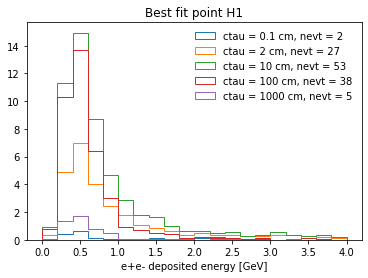

In [80]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist(df['pee', 't'][total_selection], 
                   bins=20, 
                   range=(0, 4),
                   weights=df.loc[total_selection, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[total_selection, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('e+e- deposited energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"ee_energy.png", dpi=250)

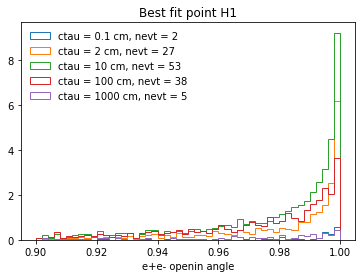

In [81]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist(df['ee_costheta', ''][total_selection], 
                   bins=50, 
                   range=(0.9, 1), 
                   weights=df.loc[total_selection, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[total_selection, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False, loc='upper left')
plt.xlabel('e+e- openin angle')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"ee_costheta.png", dpi=250)

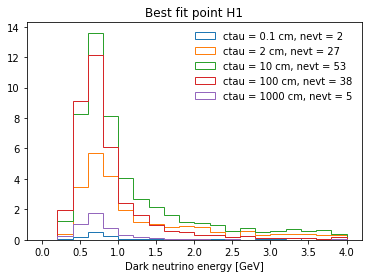

In [82]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist((df['plp', 't']+df['plm', 't']+df['pnu', 't'])[total_selection], 
                   bins=20, 
                   range=(0, 4), 
                   weights=df.loc[total_selection, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[total_selection, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('Dark neutrino energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"nu4_energy.png", dpi=250)

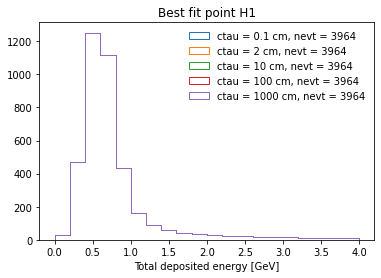

In [83]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist((df['plp', 't']+df['plm', 't']+df['pnu', 't']+df['pHad', 't']-df['recoil_mass', '']), 
                   bins=20, 
                   range=(0, 4), 
                   weights=df.loc[:, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[:, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('Total deposited energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"deposited_energy.png", dpi=250)